In [40]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv(os.getcwd() + '/Datasets/Ontario/Hourly_Electricity_Ontario.csv')
df

,time,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_depth,cloud_cover,air_density,Total Energy Use from Electricity (MW)
0,2003-01-01 00:00:00,0.0100,-1.720,0.0000,0.0000,0.0011,17.4309,0.3196,1.2612,14745
1,2003-01-01 01:00:00,0.0022,-2.045,0.0000,0.0000,0.0010,17.4307,0.3167,1.2644,14280
2,2003-01-01 02:00:00,0.0014,-2.402,0.0000,0.0000,0.0009,17.4304,0.2958,1.2669,13821
3,2003-01-01 03:00:00,0.0013,-2.732,0.0000,0.0000,0.0008,17.4302,0.3745,1.2695,13239
4,2003-01-01 04:00:00,0.0011,-3.083,0.0000,0.0000,0.0009,17.4300,0.6073,1.2724,13236
...,...,...,...,...,...,...,...,...,...,...
122731,2016-12-31 19:00:00,0.1642,0.551,65.7947,394.8765,0.0845,16.9569,0.9761,1.2408,16260
122732,2016-12-31 20:00:00,0.1857,0.455,29.8108,238.0150,0.0863,16.9597,0.9729,1.2407,15658
122733,2016-12-31 21:00:00,0.2322,0.180,4.8503,52.9368,0.1055,16.9680,0.9628,1.2417,15195
122734,2016-12-31 22:00:00,0.2462,-0.047,0.0047,0.0378,0.1173,16.9865,0.9353,1.2430,14758


In [3]:
df = df.drop(columns=["precipitation", "temperature", "irradiance_surface", "irradiance_toa", "snowfall", "snow_depth", "cloud_cover", "air_density"])

In [4]:
df = df.rename(columns={"Total Energy Use from Electricity (MW)": "Consumption", "time": "DateTime"})
df["Year"] = pd.to_datetime(df["DateTime"]).dt.year
df["Month"] = pd.to_datetime(df["DateTime"]).dt.month
df["Date"] = pd.to_datetime(df["DateTime"]).dt.date
df["Time"] = pd.to_datetime(df["DateTime"]).dt.time
df = df.set_index("DateTime")
df.index = pd.to_datetime(df.index)

In [5]:
df = df[['Time', "Date", "Month", "Year", "Consumption"]]
df

,Time,Date,Month,Year,Consumption
DateTime,,,,,
2003-01-01 00:00:00,00:00:00,2003-01-01,1,2003,14745
2003-01-01 01:00:00,01:00:00,2003-01-01,1,2003,14280
2003-01-01 02:00:00,02:00:00,2003-01-01,1,2003,13821
2003-01-01 03:00:00,03:00:00,2003-01-01,1,2003,13239
2003-01-01 04:00:00,04:00:00,2003-01-01,1,2003,13236
...,...,...,...,...,...
2016-12-31 19:00:00,19:00:00,2016-12-31,12,2016,16260
2016-12-31 20:00:00,20:00:00,2016-12-31,12,2016,15658
2016-12-31 21:00:00,21:00:00,2016-12-31,12,2016,15195


In [6]:
# Downsampling from hours to days
df_day = df.drop(columns=["Month", "Year"])
df_day = df_day.resample("D").sum()

In [7]:
df_day

,Consumption
DateTime,
2003-01-01,375753
2003-01-02,449182
2003-01-03,455246
2003-01-04,416474
2003-01-05,408879
...,...
2016-12-27,349744
2016-12-28,370750
2016-12-29,370212


In [11]:
def create_io_pair(data, k=1):
    """
        k: time step
        return input-output pair from given dataset
    """
    dataX, dataY = [], []
    for i in range(len(data) - k - 1):
        dataX.append(data[i:(i + k), 0])
        dataY.append(data[i + k, 0])
    return np.array(dataX), np.array(dataY)

In [22]:
def split_data(dataset):
    training_data_size = math.ceil(len(dataset)*.80)
    testing_size = len(dataset) - training_data_size
    validation_size = int(training_data_size*.20)
    training_data, testing_data, validation_data = dataset[0:training_data_size-validation_size, :], dataset[training_data_size:len(dataset), :1], dataset[len(dataset)-testing_size-validation_size:len(dataset)-testing_size, :1]
    return training_data, testing_data, validation_data

In [23]:
def LSTM_model(n_input, n_output, units=50, dropout_rate=0.2, optimizer='adam'):
    # using sequential to build LSTM model
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units, return_sequences = True, input_shape = (n_input, 1)))
    model.add(Dropout(dropout_rate))

    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(dropout_rate))

    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(dropout_rate))

    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units))
    model.add(Dropout(dropout_rate))

    # Adding the output layer
    model.add(Dense(units = n_output))

    # Compiling the RNN
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error')
    
    return model

In [110]:
def line_plot(y_test, y_pred):
    plt.figure(figsize=(15,10))
    plt.title('LSTM Model')
    plt.xlabel('Step')
    plt.ylabel('Total Energy Use from Electricity (MWh)')
    plt.plot(y_test, color="blue", label="actual")
    plt.plot(y_pred, color="red", label="predicted")
    plt.legend(loc="upper right")
    plt.show()

# DAILY-PREDICTION

## WITH 2003 - OUTLIERS

## Normalizing the data

In [55]:
Y = np.array(df_day["Consumption"])
Y

array([375753, 449182, 455246, ..., 370212, 368597, 356693])

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))

In [10]:
Y = scaler.fit_transform(Y.reshape(-1,1))
Y

array([[0.32751278],
       [0.58854541],
       [0.61010231],
       ...,
       [0.30781509],
       [0.30207393],
       [0.25975642]])

In [24]:
training_data, testing_data, validation_data = split_data(Y)

In [59]:
training_data.shape

(3274, 1)

In [25]:
k = 100 # step
X_train, y_train = create_io_pair(training_data, k=k)
X_test, y_test = create_io_pair(testing_data, k=k)
X_validation, y_validation = create_io_pair(validation_data, k=k)

In [26]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)

In [27]:
X_train.shape

(3173, 100, 1)

In [61]:
y_train.shape

(3173,)

In [28]:
X_test.shape

(921, 100, 1)

In [62]:
y_test.shape

(921,)

In [29]:
X_validation.shape

(717, 100, 1)

In [31]:
model = LSTM_model(X_train.shape[1], X_train.shape[2], units=50, dropout_rate=0.2, optimizer='adam')

2023-04-14 19:04:40.814911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [33]:
history = model.fit(X_train, y_train, epochs = 60, batch_size = 64)

Epoch 1/60
50/50 [==============================] - 8s 108ms/step - loss: 0.1295
Epoch 2/60
50/50 [==============================] - 5s 104ms/step - loss: 0.0988
Epoch 3/60
50/50 [==============================] - 5s 105ms/step - loss: 0.0975
Epoch 4/60
50/50 [==============================] - 5s 107ms/step - loss: 0.0964
Epoch 5/60
50/50 [==============================] - 5s 106ms/step - loss: 0.0936
Epoch 6/60
50/50 [==============================] - 5s 105ms/step - loss: 0.0950
Epoch 7/60
50/50 [==============================] - 5s 106ms/step - loss: 0.0945
Epoch 8/60
50/50 [==============================] - 5s 105ms/step - loss: 0.0937
Epoch 9/60
50/50 [==============================] - 5s 106ms/step - loss: 0.0932
Epoch 10/60
50/50 [==============================] - 5s 107ms/step - loss: 0.0915
Epoch 11/60
50/50 [==============================] - 5s 105ms/step - loss: 0.0911
Epoch 12/60
50/50 [==============================] - 5s 104ms/step - loss: 0.0924
Epoch 13/60
50/50 [======

In [34]:
y_pred = model.predict(X_test)

29/29 [==============================] - 1s 24ms/step


In [35]:
mean_absolute_error(y_pred, y_test)

0.08603677708353352

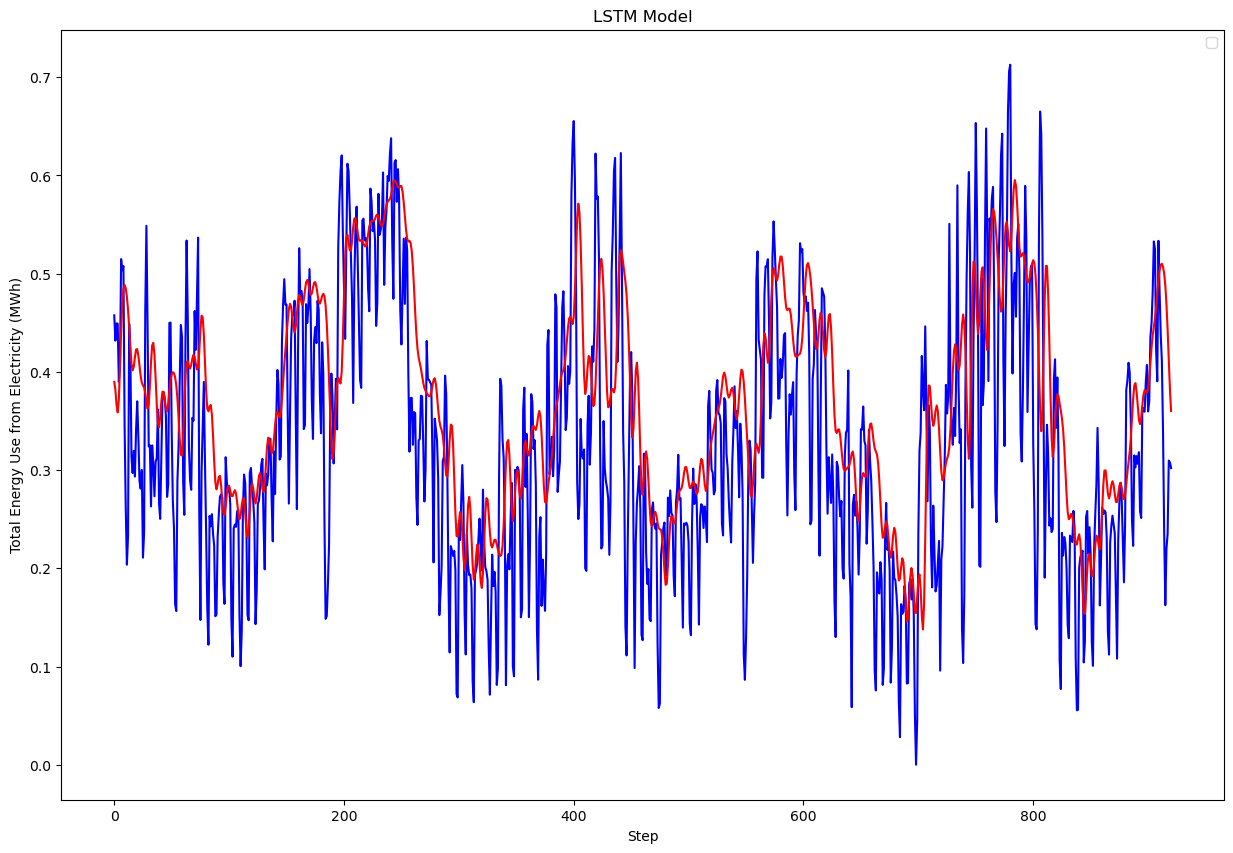

In [36]:
plt.figure(figsize=(15,10))
plt.title('LSTM Model')
plt.xlabel('Step')
plt.ylabel('Total Energy Use from Electricity (MWh)')
plt.legend(['actual', 'train_predictions'])
plt.plot(y_test, color="blue")
plt.plot(y_pred, color="red")
plt.show()

In [28]:
y_pred = scaler.inverse_transform(y_pred)

y_test = y_test.reshape(y_test.shape[0], 1)
actual_val = scaler.inverse_transform(y_test)


df_results = pd.DataFrame()
df_results["Predictions"] = y_pred.tolist()
df_results["Actuals"] = actual_val.tolist()

df_results

,Predictions,Actuals
0,[387353.21875],[412354.0]
1,[389292.25],[405099.0]
2,[388610.125],[410036.0]
3,[381895.84375],[409977.0]
4,[365678.78125],[393288.0]
...,...,...
916,[393734.5625],[345459.0]
917,[401635.09375],[349744.0]
918,[397523.90625],[370750.0]
919,[392538.75],[370212.0]


In [46]:
keras = KerasRegressor(build_fn=LSTM_model)

param_grid = {
    'n_input': [100],
    'n_output': [1],
    'units': [64, 128, 256],
    'dropout_rate': [0.1, 0.2, 0.3],
    'optimizer': ['adam', 'rmsprop']
}

grid = GridSearchCV(estimator=keras, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

/var/folders/9c/825cdscs1h9_qyc7dpjdg2dm0000gn/T/ipykernel_60001/2896549209.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras = KerasRegressor(build_fn=LSTM_model)


100/100 [==============================] - 63s 607ms/step - loss: 0.1174


In [47]:
print("Best: %f using %s", (grid_result.best_score_, grid_result.best_params_))

Best: %f using %s (-0.09556243817011516, {'dropout_rate': 0.3, 'n_input': 100, 'n_output': 1, 'optimizer': 'adam', 'units': 256})


In [49]:
lstm = LSTM_model(n_input=100, n_output=1, units=256, dropout_rate=0.3, optimizer='adam')

In [50]:
lstm.fit(X_train, y_train, epochs = 120, batch_size = 64)

Epoch 1/120
50/50 [==============================] - 61s 1s/step - loss: 0.1740
Epoch 2/120
50/50 [==============================] - 57s 1s/step - loss: 0.0933
Epoch 3/120
50/50 [==============================] - 57s 1s/step - loss: 0.0932
Epoch 4/120
50/50 [==============================] - 57s 1s/step - loss: 0.0938
Epoch 5/120
50/50 [==============================] - 218s 4s/step - loss: 0.0906
Epoch 6/120
50/50 [==============================] - 59s 1s/step - loss: 0.0936
Epoch 7/120
50/50 [==============================] - 58s 1s/step - loss: 0.0912
Epoch 8/120
50/50 [==============================] - 57s 1s/step - loss: 0.0899
Epoch 9/120
50/50 [==============================] - 57s 1s/step - loss: 0.0907
Epoch 10/120
50/50 [==============================] - 58s 1s/step - loss: 0.0889
Epoch 11/120
50/50 [==============================] - 58s 1s/step - loss: 0.0906
Epoch 12/120
50/50 [==============================] - 58s 1s/step - loss: 0.0893
Epoch 13/120
50/50 [================

50/50 [==============================] - 58s 1s/step - loss: 0.0485
Epoch 103/120
50/50 [==============================] - 58s 1s/step - loss: 0.0493
Epoch 104/120
50/50 [==============================] - 58s 1s/step - loss: 0.0487
Epoch 105/120
50/50 [==============================] - 58s 1s/step - loss: 0.0473
Epoch 106/120
50/50 [==============================] - 58s 1s/step - loss: 0.0470
Epoch 107/120
50/50 [==============================] - 58s 1s/step - loss: 0.0489
Epoch 108/120
50/50 [==============================] - 60s 1s/step - loss: 0.0469
Epoch 109/120
50/50 [==============================] - 59s 1s/step - loss: 0.0464
Epoch 110/120
50/50 [==============================] - 59s 1s/step - loss: 0.0470
Epoch 111/120
50/50 [==============================] - 59s 1s/step - loss: 0.0444
Epoch 112/120
50/50 [==============================] - 59s 1s/step - loss: 0.0444
Epoch 113/120
50/50 [==============================] - 58s 1s/step - loss: 0.0460
Epoch 114/120
50/50 [=========

In [51]:
y_pred = lstm.predict(X_test)

29/29 [==============================] - 6s 188ms/step


In [52]:
mean_absolute_error(y_pred, y_test)

0.054250749809582166

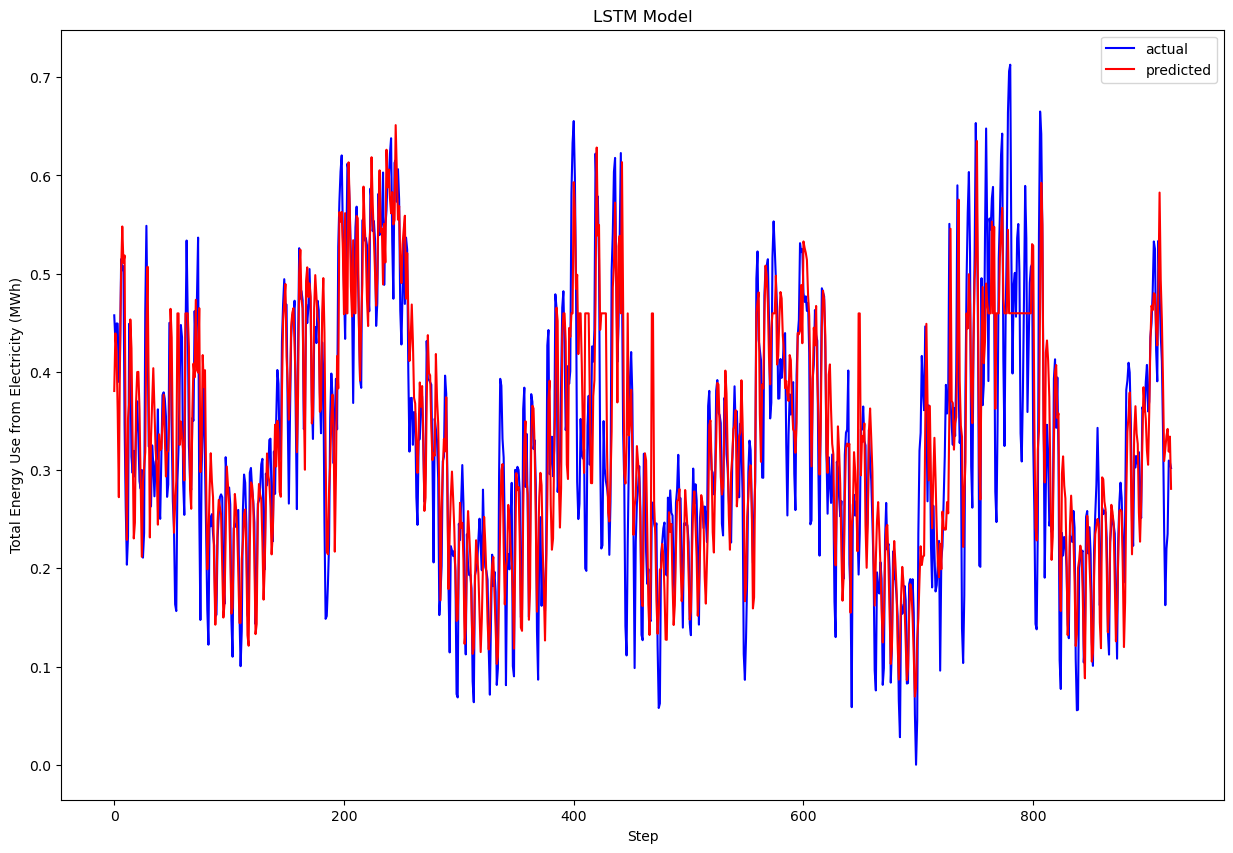

In [66]:
line_plot(y_test, y_pred)

# HOURLY PREDICTION

In [77]:
hourly_consumption = np.array(df["Consumption"])

In [78]:
hourly_consumption[:10]

array([14745, 14280, 13821, 13239, 13236, 13504, 13814, 13544, 13837,
       14623])

In [79]:
# Scaling data
scaler = MinMaxScaler(feature_range=(0,1))
hourly_consumption = scaler.fit_transform(hourly_consumption.reshape(-1,1))

In [81]:
hourly_consumption[:10]

array([[0.50434607],
       [0.4855468 ],
       [0.4669901 ],
       [0.44346068],
       [0.4433394 ],
       [0.45417425],
       [0.4667071 ],
       [0.45579139],
       [0.46763695],
       [0.49941379]])

In [108]:
hourly_consumption.shape

(122736, 1)

In [82]:
# split data
training_data, testing_data, validation_data = split_data(hourly_consumption)

In [101]:
k = 168 # step
X_train, y_train = create_io_pair(training_data, k=k)
X_test, y_test = create_io_pair(testing_data, k=k)

In [102]:
print(X_train.shape, y_train.shape)

(78383, 168) (78383,)


In [103]:
print(X_test.shape, y_test.shape)

(24378, 168) (24378,)


In [104]:
lstm = LSTM_model(n_input=k, n_output=1, units=64, dropout_rate=0.3, optimizer='adam')
lstm.fit(X_train, y_train, epochs = 30, batch_size = 64)

Epoch 1/30
1225/1225 [==============================] - 260s 208ms/step - loss: 0.0622
Epoch 2/30
1225/1225 [==============================] - 255s 208ms/step - loss: 0.0382
Epoch 3/30
1225/1225 [==============================] - 438s 358ms/step - loss: 0.0299
Epoch 4/30
1225/1225 [==============================] - 253s 207ms/step - loss: 0.0238
Epoch 5/30
1225/1225 [==============================] - 254s 207ms/step - loss: 0.0200
Epoch 6/30
1225/1225 [==============================] - 255s 208ms/step - loss: 0.0180
Epoch 7/30
1225/1225 [==============================] - 255s 208ms/step - loss: 0.0162
Epoch 8/30
1225/1225 [==============================] - 255s 208ms/step - loss: 0.0148
Epoch 9/30
1225/1225 [==============================] - 253s 207ms/step - loss: 0.0140
Epoch 10/30
1225/1225 [==============================] - 454s 371ms/step - loss: 0.0135
Epoch 11/30
1225/1225 [==============================] - 255s 208ms/step - loss: 0.0131
Epoch 12/30
1225/1225 [==================

In [105]:
y_pred = lstm.predict(X_test)

762/762 [==============================] - 42s 54ms/step


In [106]:
mean_absolute_error(y_pred, y_test)

0.008067364346490155

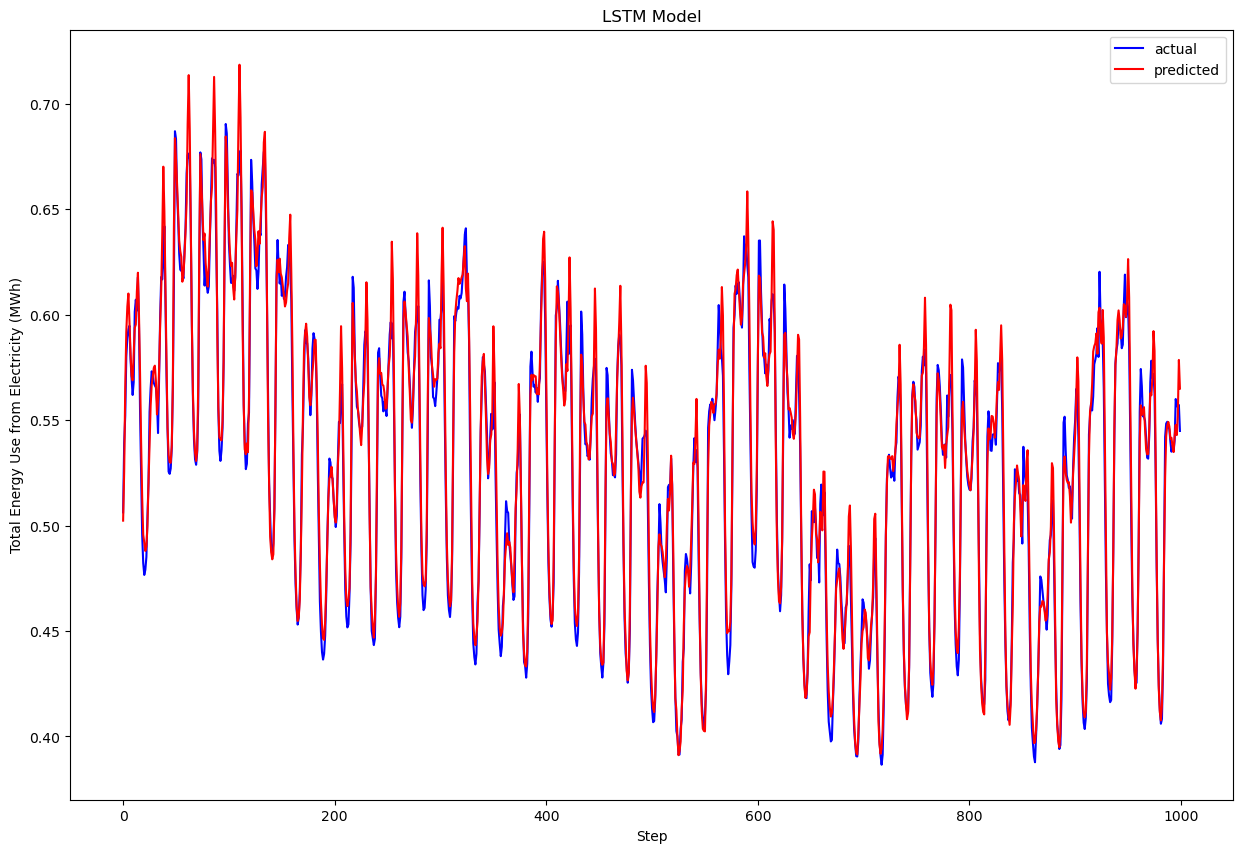

In [112]:
line_plot(y_pred[:1000], y_test[:1000])